In [3]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FREDAPI_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,mean_absolute_percentage_error,r2_score


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)



cuda


In [6]:


df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [7]:

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
bidirectional_lstm = BiLSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [9]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        

/tmp/ipykernel_106601/3037039946.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_106601/3037039946.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4483; Test RSME: 0.1352
Epoch: 1; train_RSEM: 0.4309; Test RSME: 0.1189
Epoch: 2; train_RSEM: 0.4137; Test RSME: 0.1028
Epoch: 3; train_RSEM: 0.3965; Test RSME: 0.08702
Epoch: 4; train_RSEM: 0.3793; Test RSME: 0.07182
Epoch: 5; train_RSEM: 0.3621; Test RSME: 0.05772
Epoch: 6; train_RSEM: 0.3448; Test RSME: 0.04599
Epoch: 7; train_RSEM: 0.3275; Test RSME: 0.0392
Epoch: 8; train_RSEM: 0.3101; Test RSME: 0.04041
Epoch: 9; train_RSEM: 0.2927; Test RSME: 0.04948
Epoch: 10; train_RSEM: 0.2755; Test RSME: 0.06348
Epoch: 11; train_RSEM: 0.2585; Test RSME: 0.08018
Epoch: 12; train_RSEM: 0.2419; Test RSME: 0.09845
Epoch: 13; train_RSEM: 0.2261; Test RSME: 0.1177
Epoch: 14; train_RSEM: 0.2114; Test RSME: 0.1377
Epoch: 15; train_RSEM: 0.1982; Test RSME: 0.158
Epoch: 16; train_RSEM: 0.187; Test RSME: 0.1786
Epoch: 17; train_RSEM: 0.1784; Test RSME: 0.199
Epoch: 18; train_RSEM: 0.1726; Test RSME: 0.219
Epoch: 19; train_RSEM: 0.1697; Test RSME: 0.2382
Epoch: 20; train_RSEM: 0.

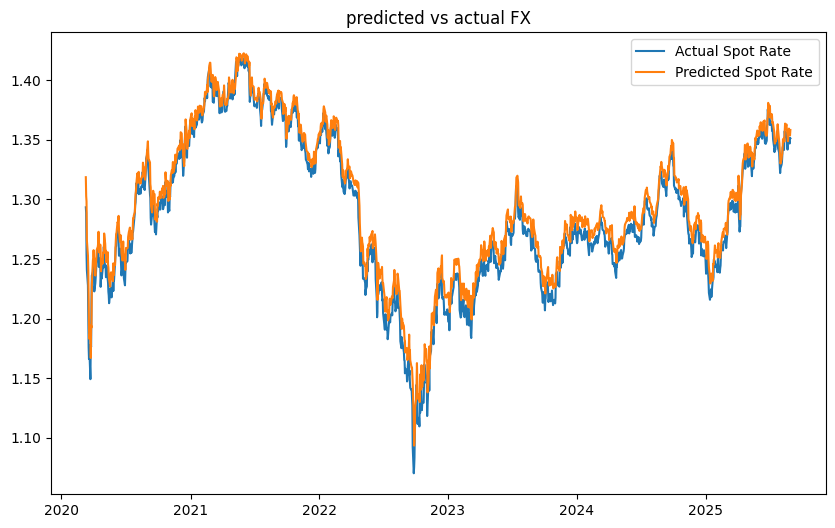

In [10]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


bilstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual FX")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_bidirectional_lstm.png")
plt.show()

In [11]:
# Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test_np,pred_np)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

# R2 Score
r2 = r2_score(y_test_np,pred_np)
print(f'R2 Score: {r2*100:2f}%')


# root mean squared error
rmse = root_mean_squared_error(y_test_np,pred_np)
print(f'Root Mean Squared Error: {rmse:.4f}')





print(np.round(bilstm_comparison_df,4).head(20))
print(np.round(bilstm_comparison_df,4).tail(20))


Mean Absolute Percentage Error: 0.0580
R2 Score: 96.216959%
Root Mean Squared Error: 0.0079
            Date  Actual Spot Rate  Predicted Spot Rate
12338 2020-03-10            1.2933               1.3186
12339 2020-03-11            1.2887               1.3027
12340 2020-03-12            1.2541               1.2983
12341 2020-03-13            1.2406               1.2656
12342 2020-03-16            1.2278               1.2528
12343 2020-03-17            1.2017               1.2408
12344 2020-03-18            1.1760               1.2162
12345 2020-03-19            1.1662               1.1921
12346 2020-03-20            1.1743               1.1829
12347 2020-03-23            1.1492               1.1905
12348 2020-03-24            1.1784               1.1670
12349 2020-03-25            1.1763               1.1943
12350 2020-03-26            1.2140               1.1924
12351 2020-03-27            1.2360               1.2278
12352 2020-03-30            1.2392               1.2485
12353 2020-0